In [138]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go

import networkx as nx
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [139]:
plt.style.use("bmh")
alph = 0.5

In [140]:
def extract_numerical_categorical_features(data:pd.DataFrame, exclude_col:list):
    """
    Extract the categorical and numerical features of a dataset
    Args:
    data: the dataframe
    label: the label we do not want to import
    """
    numerical_features = [key for key, value in data.dtypes.items() if value=="float64" and key not in exclude_col]
    print(f"Numerical features: {numerical_features}")

    #categorical_features = [key for key, value in data.dtypes.items() if value=="object" and key!=label]
    categorical_features = [col for col in data.columns if col not in (numerical_features+exclude_col)]
    print(f"Categorical features: {categorical_features}")
    
    return numerical_features, categorical_features

In [141]:
df = pd.read_csv("data_cleaned.csv", index_col=0)
df_std = pd.read_csv("data_cleaned_standardized.csv", index_col=0)

In [142]:
#numerical_features = ["Movie_release_date","Movie_box_office_revenue","Movie_runtime",
#                      "Actor_age_at_movie_release","Actor_height_m"]
#categorical_features = ["Main_genre","Region"]
label = ["Actor_gender_male"]
col2exclude = label + ["Movie_name", "Actor_name"]
numerical_features, categorical_features = extract_numerical_categorical_features(df, col2exclude)

Numerical features: ['Movie_release_date', 'Movie_box_office_scaled', 'Movie_runtime', 'Actor_height_scaled', 'Actor_age_at_movie_release']
Categorical features: ['Cluster_Name_B&W - Indie', 'Cluster_Name_Comedy - Action', 'Cluster_Name_Comedy - Short film', 'Cluster_Name_Crime - Thriller', 'Cluster_Name_Drama', 'Cluster_Name_Drama - B&W', 'Cluster_Name_Drama - Comedy', 'Cluster_Name_Drama - Indie', 'Cluster_Name_Drama - Romance', 'Cluster_Name_Drama - Thriller', 'Cluster_Name_Romance - Comedy', 'Cluster_Name_Short film - World cinema', 'Cluster_Name_Thriller', 'Region_Asia', 'Region_Dead country', 'Region_East Europa', 'Region_North America', 'Region_Oceania', 'Region_South America', 'Region_West Europa']


In [143]:
X_train_std = df_std[[col for col in df_std.columns if col not in col2exclude]]
X_train = df[[col for col in df_std.columns if col not in col2exclude]]
y_train = df_std[label]

In [144]:
X_train.head(5)

,Movie_release_date,Movie_box_office_scaled,Movie_runtime,Actor_height_scaled,Actor_age_at_movie_release,Cluster_Name_B&W - Indie,Cluster_Name_Comedy - Action,Cluster_Name_Comedy - Short film,Cluster_Name_Crime - Thriller,Cluster_Name_Drama,...,Cluster_Name_Romance - Comedy,Cluster_Name_Short film - World cinema,Cluster_Name_Thriller,Region_Asia,Region_Dead country,Region_East Europa,Region_North America,Region_Oceania,Region_South America,Region_West Europa
0,2001.0,7.912729e+06,98.0,1.031847,42.0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,2001.0,7.912729e+06,98.0,1.133758,27.0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,2001.0,7.912729e+06,98.0,0.990877,32.0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,2001.0,7.912729e+06,98.0,1.004074,33.0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,2001.0,7.912729e+06,98.0,1.050955,23.0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


# Biases

penser à compter l'inflation pour le box office et "standardiser" les tailles des acteurs

In [145]:
#OLD BOXPLOT DE THOMAS
'''plt.figure(figsize=(20, 6))
for i,col in enumerate(numerical_features):
    plt.subplot(1,len(numerical_features),i+1)
    sns.boxplot(data=df, x=df[label[0]], y=df[col], boxprops=dict(alpha=alph))
    plt.ylim([-1e7, 1.5e8]) if col=="Movie_box_office_scaled" else None
    plt.ylim([0,200]) if col=="Movie_runtime" else None
plt.show()'''

'plt.figure(figsize=(20, 6))\nfor i,col in enumerate(numerical_features):\n    plt.subplot(1,len(numerical_features),i+1)\n    sns.boxplot(data=df, x=df[label[0]], y=df[col], boxprops=dict(alpha=alph))\n    plt.ylim([-1e7, 1.5e8]) if col=="Movie_box_office_scaled" else None\n    plt.ylim([0,200]) if col=="Movie_runtime" else None\nplt.show()'

In [161]:
fig = go.Figure()

for i, feature in enumerate(numerical_features):
    #add boxplot for female
    fig.add_trace(go.Box(y=df[df[label[0]] == 0][feature],name="Female",visible=(i==0),hoverinfo="y",marker_color='indianred'))
    #add boxplot for male
    fig.add_trace(go.Box(y=df[df[label[0]] == 1][feature],name="Male",visible=(i==0),hoverinfo="y",marker_color='blue'))

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            showactive=True,
            x=0.5,xanchor="center",
            y=1.1,yanchor="top",
            buttons=[
                dict(label="Release date", method="update", args=[{"visible": [True, True, False, False, False, False, False, False, False, False]},{"yaxis": {"range": None}}]),
                dict(label="Box office (scaled)", method="update", args=[{"visible": [False, False, True, True, False, False, False, False, False, False]},{"yaxis": {"range": [-1e7, 1.5e8]}}]),
                dict(label="Runtime", method="update", args=[{"visible": [False, False, False, False, True, True, False, False, False, False]},{"yaxis": {"range": [0,200]}}]),
                dict(label="Height (scaled)", method="update", args=[{"visible": [False, False, False, False, False, False, True, True,  False, False]},{"yaxis": {"range": [0.7,1.3]}}]),
                dict(label="Age", method="update", args=[{"visible": [False, False, False, False, False, False, False, False, True, True]},{"yaxis": {"range": None}}])
            ]
        )
    ],
    title="Bias Analysis by Numerical Feature",
    title_x=0.5
)

fig.write_html("boxplot_bias.html")
print("HTML Boxplot saved.")


HTML Boxplot saved.


# Matching the data for further analysis

In [162]:
#Create the control and treated groups
df_male = df[df[label[0]] == 1]
df_female = df[df[label[0]] == 0]

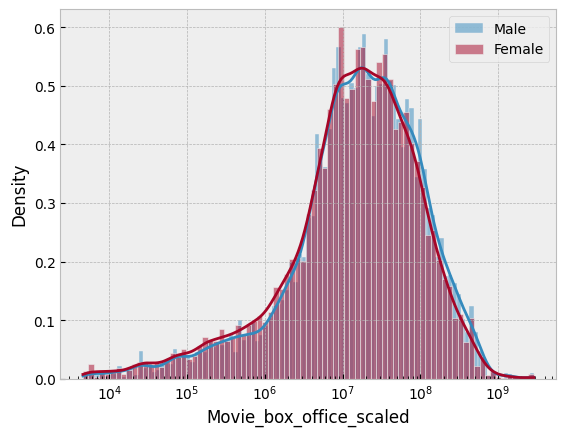

In [163]:
ax = sns.histplot(df_male["Movie_box_office_scaled"], kde=True, stat='density', label="Male", log_scale=True, alpha=alph)
ax = sns.histplot(df_female["Movie_box_office_scaled"], kde=True, stat='density', label="Female", alpha=alph)
plt.legend()
plt.show()

# Decision tree

In [164]:
tree1 = DecisionTreeClassifier(max_depth = 1)
tree1.fit(X_train, y_train)
tree1_depth = tree1.get_depth()
print(f"The tree has a depth of {tree1_depth}")

The tree has a depth of 1


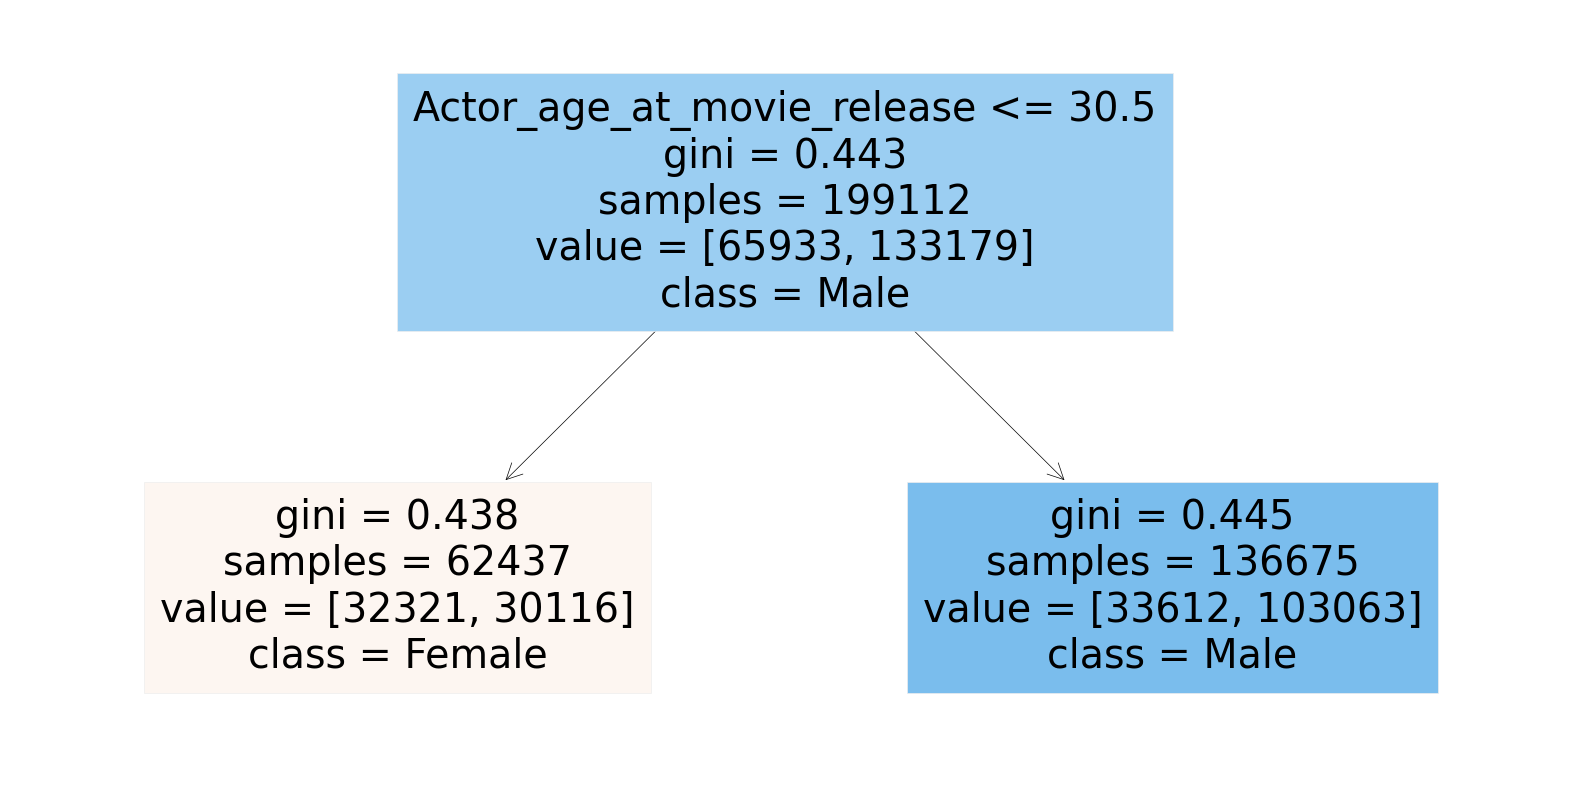

In [165]:
plt.figure(figsize=(20,10), dpi=100)
plot_tree(tree1, filled=True, feature_names=X_train.columns, class_names=["Female", "Male"])
plt.show()